In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
olympic_data = pd.read_csv('../csv/olympic_data_cleaned.csv')
olympic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_year         2889 non-null   int64 
 1   country_name      2889 non-null   object
 2   total_medals      2889 non-null   int64 
 3   gold_medals       2889 non-null   int64 
 4   silver_medals     2889 non-null   int64 
 5   bronze_medals     2889 non-null   int64 
 6   sports            2889 non-null   int64 
 7   epreuves          2889 non-null   int64 
 8   game_part         2889 non-null   int64 
 9   prec_game_medal   2889 non-null   int64 
 10  prec_game_gold    2889 non-null   int64 
 11  prec_game_silver  2889 non-null   int64 
 12  prec_game_bronze  2889 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 293.5+ KB


In [3]:
X = olympic_data.drop(columns=['total_medals'])
y = olympic_data['total_medals']

# Identifier les colonnes non numériques

In [4]:
non_numeric_columns = X.select_dtypes(include=['object']).columns

# Encodage des colonnes non numériques

In [5]:
label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Vérifier les valeurs manquantes et les imputer avec la moyenne

In [6]:
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Séparation des données en ensembles d'entraînement et de test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Convertir les données en tenseurs PyTorch après prétraitement

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]

# Définir l'architecture du modèle ANN avec les nouveaux meilleurs hyperparamètres

In [10]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Instancier le modèle

In [11]:
model = SimpleANN(input_dim)

# Définir la fonction de perte et l'optimiseur

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Early stopping parameters => arrêter l'entraînement lorsque la performance sur l'ensemble de validation ne s'améliore plus

In [13]:
patience = 10
min_delta = 0.001
best_loss = np.inf
patience_counter = 0

# Entrainement du modèle avec early stopping

In [14]:
num_epochs = 200
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Condition d'arrét
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch [10/200], Train Loss: 78.1580, Val Loss: 53.0425
Epoch [20/200], Train Loss: 20.8766, Val Loss: 12.2084
Epoch [30/200], Train Loss: 2.2856, Val Loss: 2.9680
Epoch [40/200], Train Loss: 3.4635, Val Loss: 2.8826
Epoch [50/200], Train Loss: 1.3849, Val Loss: 1.0330
Epoch [60/200], Train Loss: 1.0914, Val Loss: 1.1311
Epoch [70/200], Train Loss: 0.6910, Val Loss: 0.6190
Epoch [80/200], Train Loss: 0.5370, Val Loss: 0.4580
Epoch [90/200], Train Loss: 0.3878, Val Loss: 0.3455
Epoch [100/200], Train Loss: 0.2780, Val Loss: 0.2625
Epoch [110/200], Train Loss: 0.2049, Val Loss: 0.1985
Epoch [120/200], Train Loss: 0.1544, Val Loss: 0.1544
Epoch [130/200], Train Loss: 0.1186, Val Loss: 0.1210
Epoch [140/200], Train Loss: 0.0939, Val Loss: 0.0973
Epoch [150/200], Train Loss: 0.0759, Val Loss: 0.0808
Epoch [160/200], Train Loss: 0.0635, Val Loss: 0.0700
Epoch [170/200], Train Loss: 0.0543, Val Loss: 0.0624
Epoch [180/200], Train Loss: 0.0472, Val Loss: 0.0567
Epoch [190/200], Train Loss: 0.04

# Visualiser les pertes d'entraînement et de validation au fil des epoch

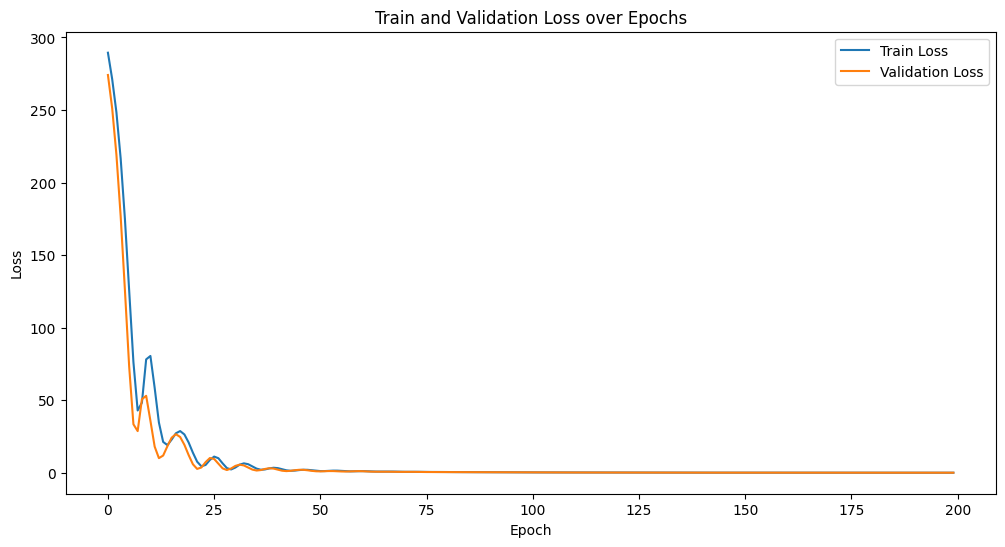

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

# Perte finale sur l'ensemble de validation

In [16]:
final_val_loss = val_losses[-1]
print(f'Final Validation Loss: {final_val_loss:.4f}')

Final Validation Loss: 0.0471


In [19]:
torch.save(model.state_dict(), '../models/olympic_medals_ann.pth')
print('Model créé avec sucées')

Model créé avec sucées
Test Loss: 0.0471
Mean Absolute Percentage Error: inf%


C:\Users\tcaron\AppData\Local\Temp\ipykernel_46316\2223404723.py:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
